#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train_cleaned_rnn.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 1339
- Negative: 18950
- Verhältnis: 14.152352501867066


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

id                   0
label                0
tweet                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           16068
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [10]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [11]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [12]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [13]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [14]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [15]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [16]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [17]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [18]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [20]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [22]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [23]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [24]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [25]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 93.64%
------------------------------------------------
Confusion Matrix:
      0   1
0  5665   9
1   378  35
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.80      0.08      0.15       413

    accuracy                           0.94      6087
   macro avg       0.87      0.54      0.56      6087
weighted avg       0.93      0.94      0.91      6087



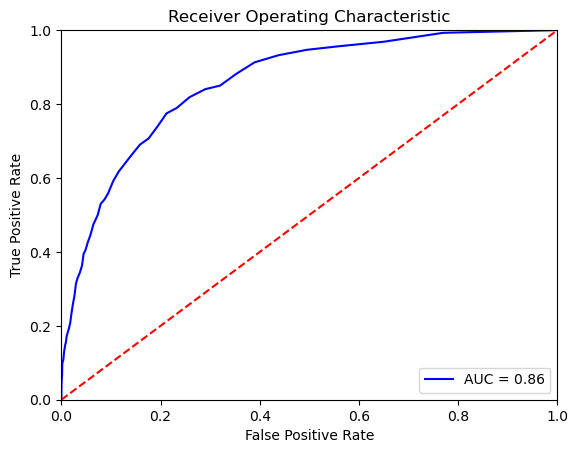

In [26]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.33%
------------------------------------------------
Confusion Matrix:
      0   1
0  5664  10
1   396  17
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      5674
           1       0.63      0.04      0.08       413

    accuracy                           0.93      6087
   macro avg       0.78      0.52      0.52      6087
weighted avg       0.91      0.93      0.91      6087



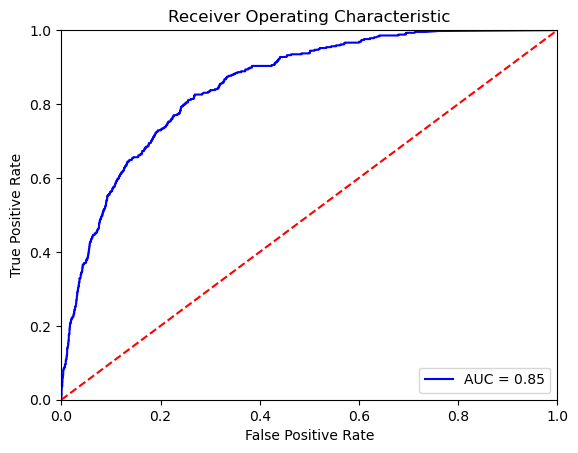

In [27]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.69%
------------------------------------------------
Confusion Matrix:
      0   1
0  5666   8
1   376  37
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.82      0.09      0.16       413

    accuracy                           0.94      6087
   macro avg       0.88      0.54      0.56      6087
weighted avg       0.93      0.94      0.91      6087



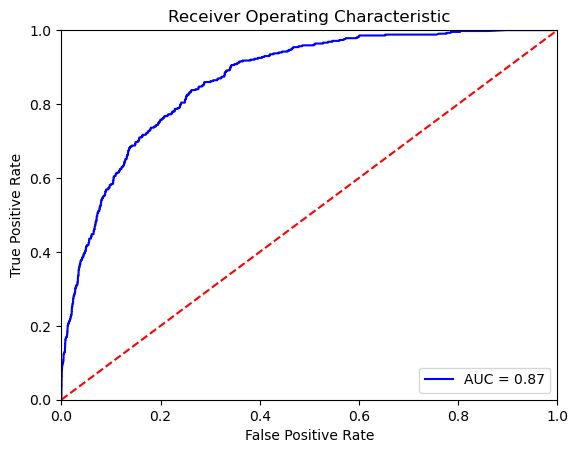

In [28]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 81.47%
------------------------------------------------
Confusion Matrix:
      0     1
0  4627  1047
1    81   332
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5674
           1       0.24      0.80      0.37       413

    accuracy                           0.81      6087
   macro avg       0.61      0.81      0.63      6087
weighted avg       0.93      0.81      0.86      6087



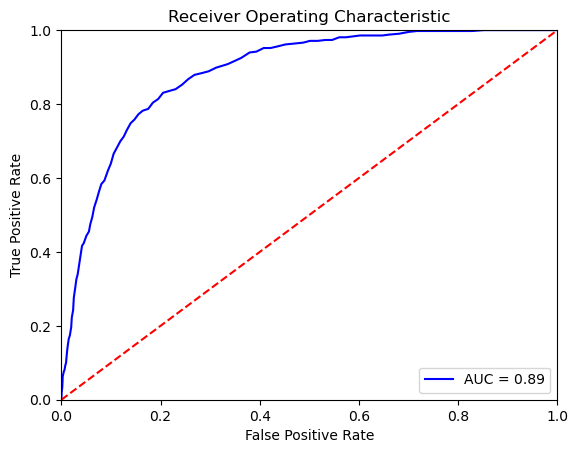

In [29]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 93.86%
------------------------------------------------
Confusion Matrix:
      0   1
0  5637  37
1   337  76
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.67      0.18      0.29       413

    accuracy                           0.94      6087
   macro avg       0.81      0.59      0.63      6087
weighted avg       0.93      0.94      0.92      6087



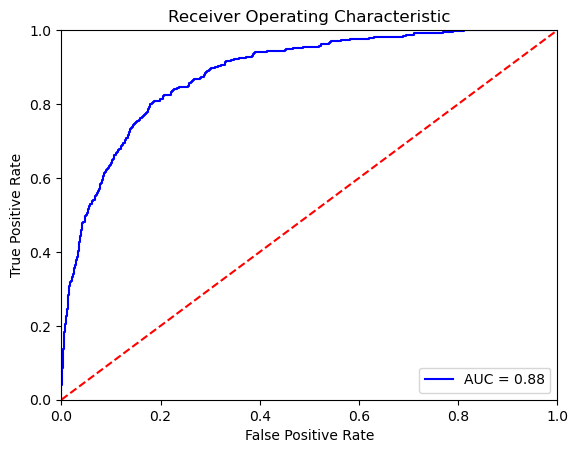

In [30]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.74%
------------------------------------------------
Confusion Matrix:
      0   1
0  5636  38
1   343  70
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.65      0.17      0.27       413

    accuracy                           0.94      6087
   macro avg       0.80      0.58      0.62      6087
weighted avg       0.92      0.94      0.92      6087



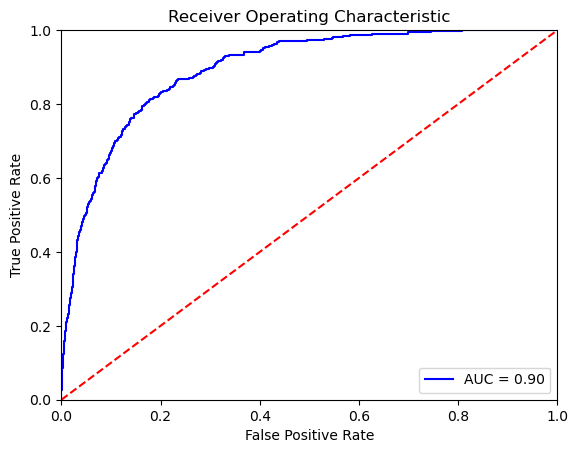

In [31]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.56%
------------------------------------------------
Confusion Matrix:
      0   1
0  5633  41
1   351  62
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.60      0.15      0.24       413

    accuracy                           0.94      6087
   macro avg       0.77      0.57      0.60      6087
weighted avg       0.92      0.94      0.92      6087



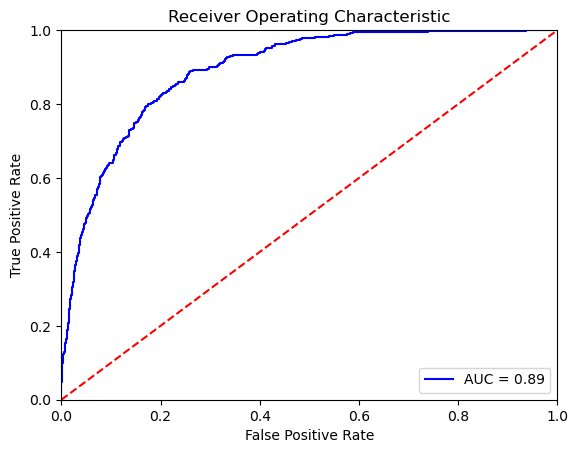

In [32]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:57:11] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 93.43%
------------------------------------------------
Confusion Matrix:
      0   1
0  5602  72
1   328  85
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.54      0.21      0.30       413

    accuracy                           0.93      6087
   macro avg       0.74      0.60      0.63      6087
weighted avg       0.92      0.93      0.92      6087



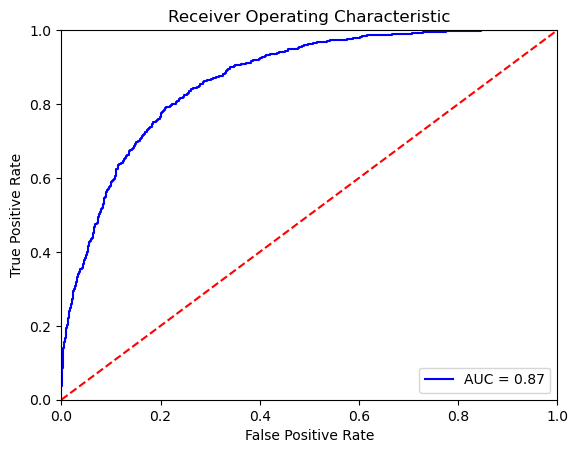

In [33]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.5733774	total: 158ms	remaining: 15.7s
1:	learn: 0.4712656	total: 182ms	remaining: 8.92s
2:	learn: 0.4078119	total: 204ms	remaining: 6.59s
3:	learn: 0.3561016	total: 226ms	remaining: 5.42s
4:	learn: 0.3170252	total: 249ms	remaining: 4.73s
5:	learn: 0.2864847	total: 271ms	remaining: 4.24s
6:	learn: 0.2626236	total: 292ms	remaining: 3.88s
7:	learn: 0.2467872	total: 314ms	remaining: 3.61s
8:	learn: 0.2344331	total: 337ms	remaining: 3.4s
9:	learn: 0.2263749	total: 360ms	remaining: 3.24s
10:	learn: 0.2163837	total: 382ms	remaining: 3.09s
11:	learn: 0.2095190	total: 404ms	remaining: 2.96s
12:	learn: 0.2041306	total: 427ms	remaining: 2.86s
13:	learn: 0.1985868	total: 450ms	remaining: 2.76s
14:	learn: 0.1941684	total: 473ms	remaining: 2.68s
15:	learn: 0.1906624	total: 498ms	remaining: 2.62s
16:	learn: 0.1880624	total: 520ms	remaining: 2.54s
17:	learn: 0.1854318	total: 542ms	remaining: 2.47s
18:	learn: 0.1837509	total: 566ms	remaining: 2.41s
19:	learn: 0.1815479	total: 589ms	remainin

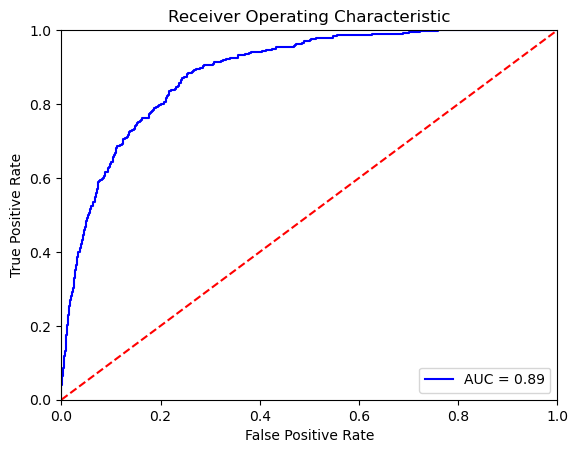

In [34]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 926, number of negative: 13275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 14201, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065207 -> initscore=-2.662764
[LightGBM] [Info] Start training from score -2.662764
model accuracy for classification is = 93.63%
------------------------------------------------
Confusion Matrix:
      0   1
0  5631  43
1   345  68
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.61      0.16      0.26       413

    accuracy                           0.94      6087
   macro avg       0.78      0.58      0.61      6087
weighted avg 

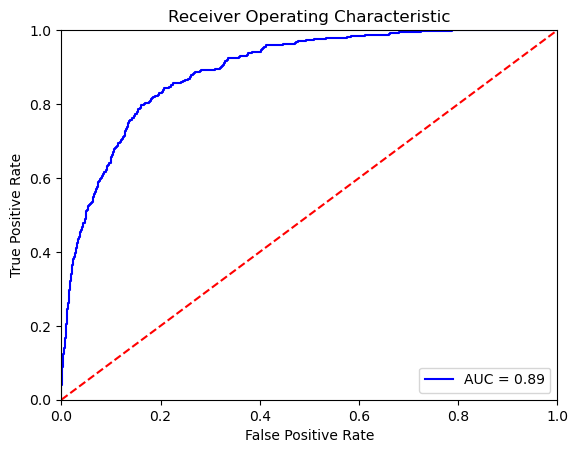

In [35]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 93.46%
------------------------------------------------
Confusion Matrix:
      0   1
0  5608  66
1   332  81
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5674
           1       0.55      0.20      0.29       413

    accuracy                           0.93      6087
   macro avg       0.75      0.59      0.63      6087
weighted avg       0.92      0.93      0.92      6087



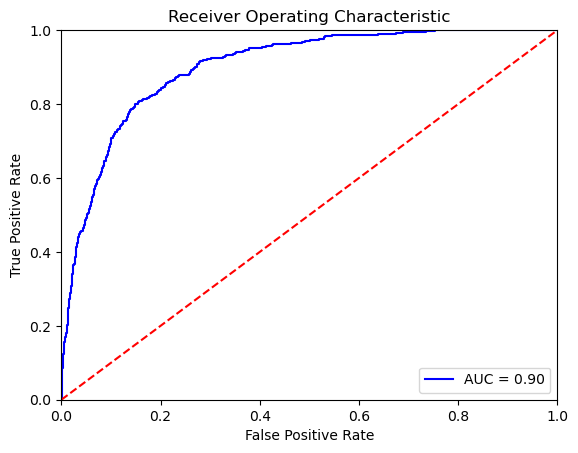

In [36]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [37]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 95.20%
------------------------------------------------
Confusion Matrix:
      0    1
0  5653   21
1   271  142
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5674
           1       0.87      0.34      0.49       413

    accuracy                           0.95      6087
   macro avg       0.91      0.67      0.73      6087
weighted avg       0.95      0.95      0.94      6087



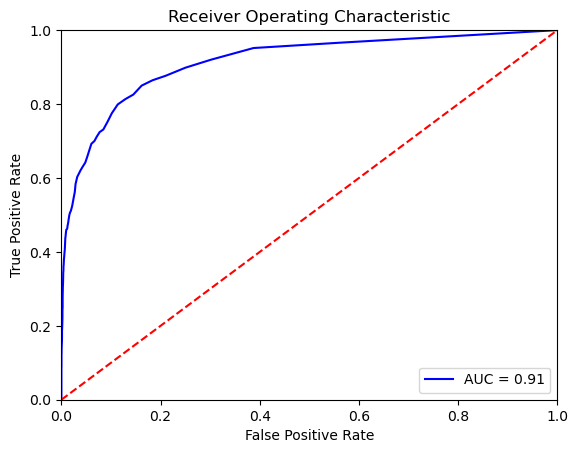

In [38]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.22%
------------------------------------------------
Confusion Matrix:
      0   1
0  5644  30
1   322  91
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.75      0.22      0.34       413

    accuracy                           0.94      6087
   macro avg       0.85      0.61      0.66      6087
weighted avg       0.93      0.94      0.93      6087



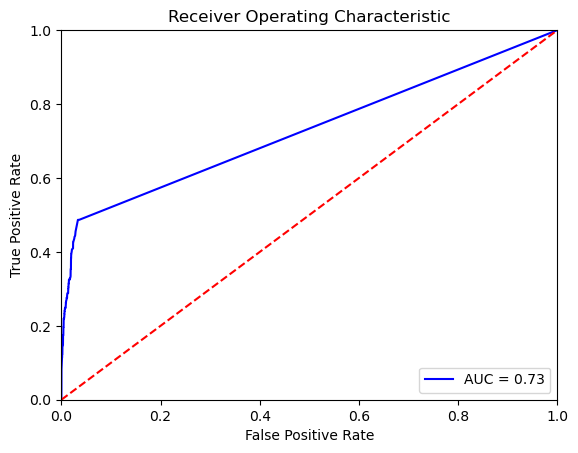

In [39]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 93.51%
------------------------------------------------
Confusion Matrix:
      0   1
0  5674   0
1   395  18
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      5674
           1       1.00      0.04      0.08       413

    accuracy                           0.94      6087
   macro avg       0.97      0.52      0.52      6087
weighted avg       0.94      0.94      0.91      6087



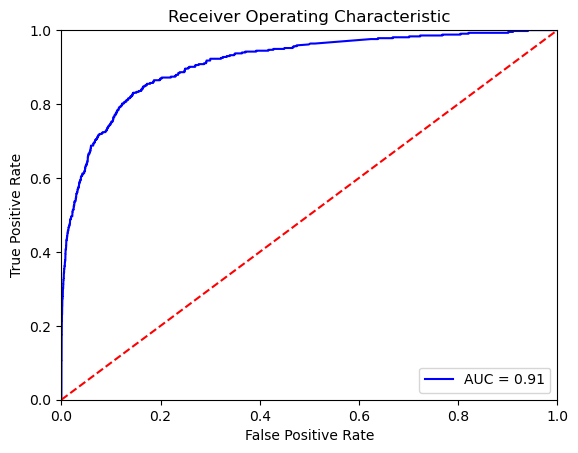

In [40]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 81.14%
------------------------------------------------
Confusion Matrix:
      0     1
0  4600  1074
1    74   339
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5674
           1       0.24      0.82      0.37       413

    accuracy                           0.81      6087
   macro avg       0.61      0.82      0.63      6087
weighted avg       0.93      0.81      0.85      6087



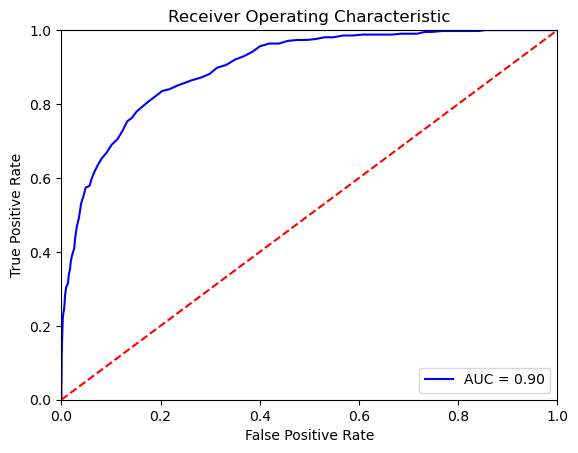

In [41]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.73%
------------------------------------------------
Confusion Matrix:
      0    1
0  5641   33
1   288  125
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.79      0.30      0.44       413

    accuracy                           0.95      6087
   macro avg       0.87      0.65      0.71      6087
weighted avg       0.94      0.95      0.94      6087



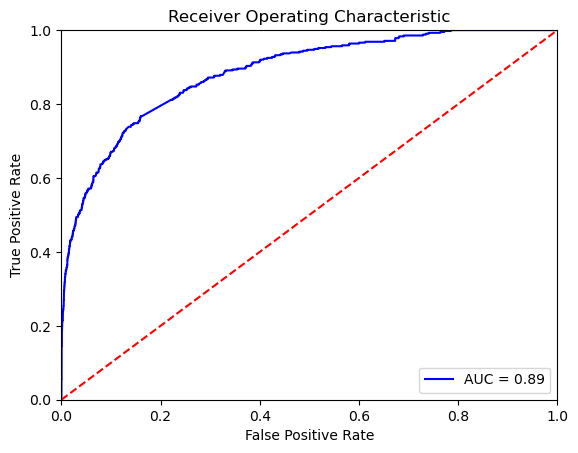

In [42]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.37%
------------------------------------------------
Confusion Matrix:
      0    1
0  5620   54
1   289  124
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.70      0.30      0.42       413

    accuracy                           0.94      6087
   macro avg       0.82      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



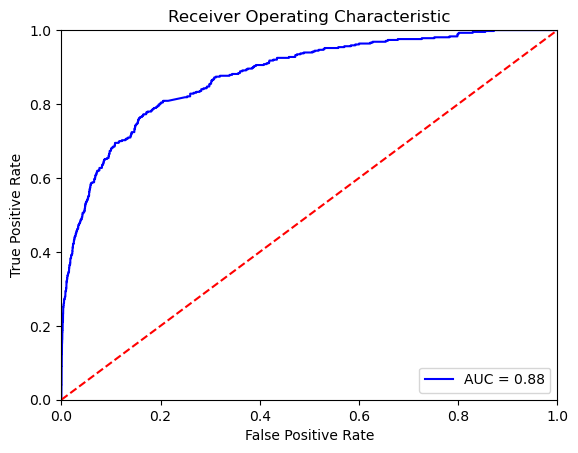

In [43]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 94.23%
------------------------------------------------
Confusion Matrix:
      0    1
0  5636   38
1   313  100
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.72      0.24      0.36       413

    accuracy                           0.94      6087
   macro avg       0.84      0.62      0.67      6087
weighted avg       0.93      0.94      0.93      6087



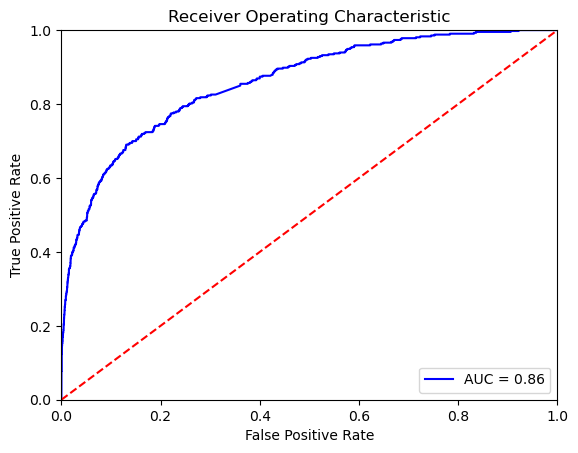

In [44]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:59:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.00%
------------------------------------------------
Confusion Matrix:
      0    1
0  5610   64
1   301  112
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.64      0.27      0.38       413

    accuracy                           0.94      6087
   macro avg       0.79      0.63      0.67      6087
weighted avg       0.93      0.94      0.93      6087



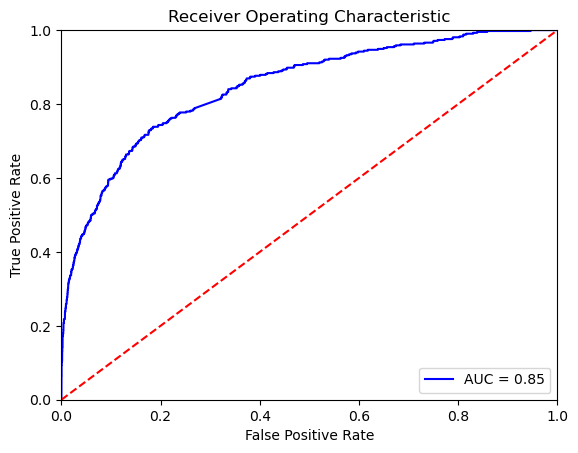

In [45]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.5858038	total: 80.5ms	remaining: 7.97s
1:	learn: 0.5044487	total: 157ms	remaining: 7.7s
2:	learn: 0.4421598	total: 241ms	remaining: 7.78s
3:	learn: 0.3925543	total: 342ms	remaining: 8.2s
4:	learn: 0.3563120	total: 430ms	remaining: 8.17s
5:	learn: 0.3264342	total: 506ms	remaining: 7.93s
6:	learn: 0.3015693	total: 597ms	remaining: 7.93s
7:	learn: 0.2826535	total: 699ms	remaining: 8.04s
8:	learn: 0.2688912	total: 779ms	remaining: 7.88s
9:	learn: 0.2564681	total: 859ms	remaining: 7.73s
10:	learn: 0.2469143	total: 932ms	remaining: 7.54s
11:	learn: 0.2400296	total: 1.01s	remaining: 7.41s
12:	learn: 0.2344608	total: 1.09s	remaining: 7.31s
13:	learn: 0.2287402	total: 1.19s	remaining: 7.31s
14:	learn: 0.2246132	total: 1.29s	remaining: 7.3s
15:	learn: 0.2205687	total: 1.38s	remaining: 7.23s
16:	learn: 0.2177155	total: 1.47s	remaining: 7.17s
17:	learn: 0.2149154	total: 1.55s	remaining: 7.07s
18:	learn: 0.2124877	total: 1.64s	remaining: 6.97s
19:	learn: 0.2106084	total: 1.72s	remaining

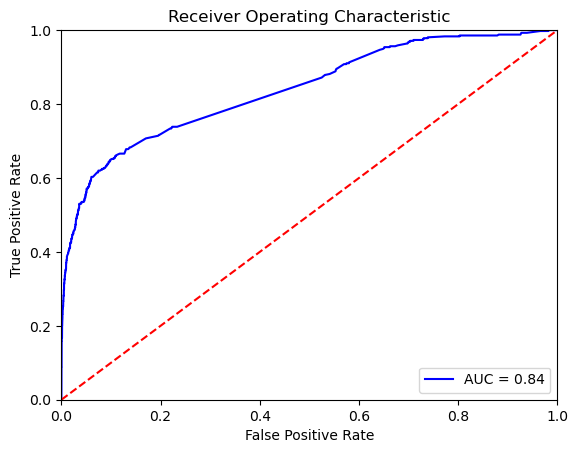

In [46]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 926, number of negative: 13275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35361
[LightGBM] [Info] Number of data points in the train set: 14201, number of used features: 1085
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065207 -> initscore=-2.662764
[LightGBM] [Info] Start training from score -2.662764
model accuracy for classification is = 94.25%
------------------------------------------------
Confusion Matrix:
      0    1
0  5616   58
1   292  121
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.68      0.29      0.41       413

    accuracy                           0.94      6087

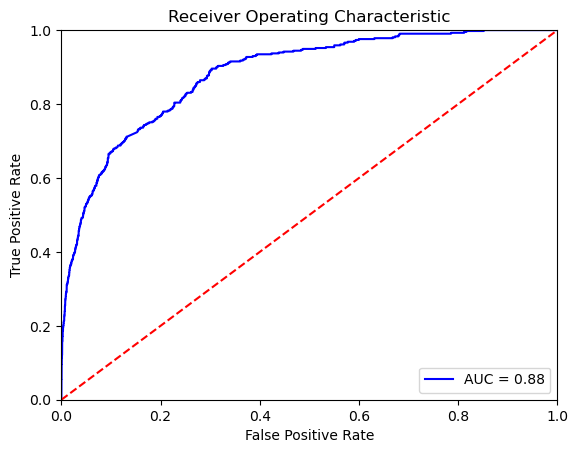

In [47]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 95.47%
------------------------------------------------
Confusion Matrix:
      0    1
0  5600   74
1   202  211
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5674
           1       0.74      0.51      0.60       413

    accuracy                           0.95      6087
   macro avg       0.85      0.75      0.79      6087
weighted avg       0.95      0.95      0.95      6087



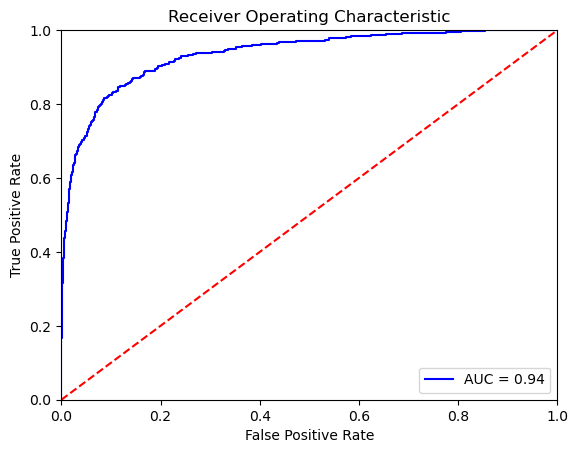

In [48]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [49]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 93.74%
------------------------------------------------
Confusion Matrix:
      0   1
0  5663  11
1   370  43
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.80      0.10      0.18       413

    accuracy                           0.94      6087
   macro avg       0.87      0.55      0.58      6087
weighted avg       0.93      0.94      0.91      6087



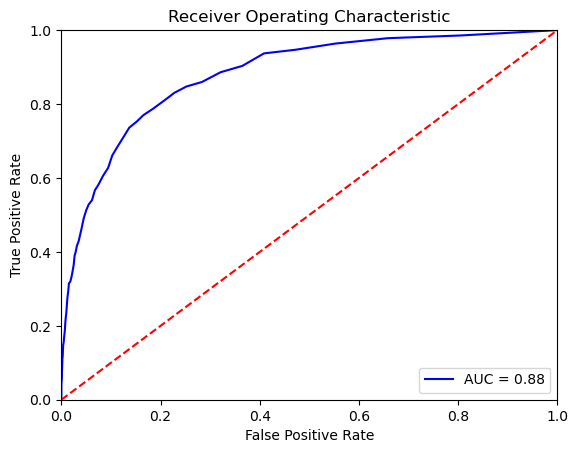

In [50]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 93.45%
------------------------------------------------
Confusion Matrix:
      0   1
0  5661  13
1   386  27
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.68      0.07      0.12       413

    accuracy                           0.93      6087
   macro avg       0.81      0.53      0.54      6087
weighted avg       0.92      0.93      0.91      6087



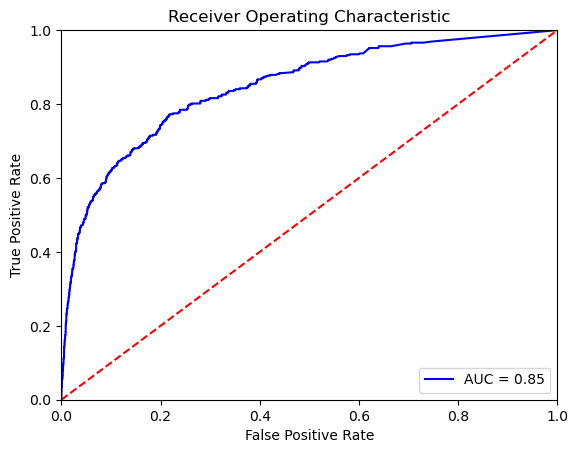

In [51]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 93.74%
------------------------------------------------
Confusion Matrix:
      0   1
0  5664  10
1   371  42
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5674
           1       0.81      0.10      0.18       413

    accuracy                           0.94      6087
   macro avg       0.87      0.55      0.57      6087
weighted avg       0.93      0.94      0.91      6087



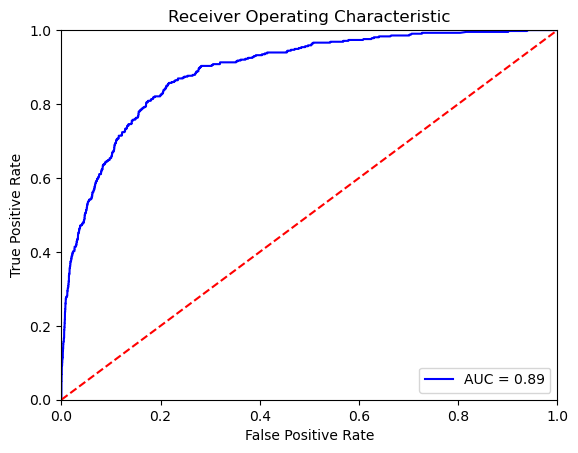

In [52]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 83.03%
------------------------------------------------
Confusion Matrix:
      0    1
0  4705  969
1    64  349
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      5674
           1       0.26      0.85      0.40       413

    accuracy                           0.83      6087
   macro avg       0.63      0.84      0.65      6087
weighted avg       0.94      0.83      0.87      6087



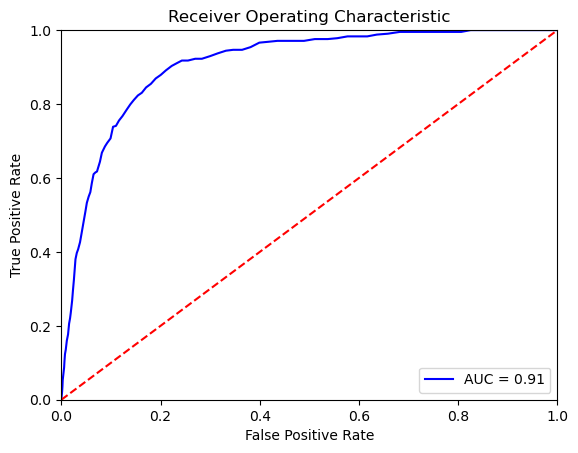

In [53]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.17%
------------------------------------------------
Confusion Matrix:
      0    1
0  5599   75
1   280  133
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.64      0.32      0.43       413

    accuracy                           0.94      6087
   macro avg       0.80      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



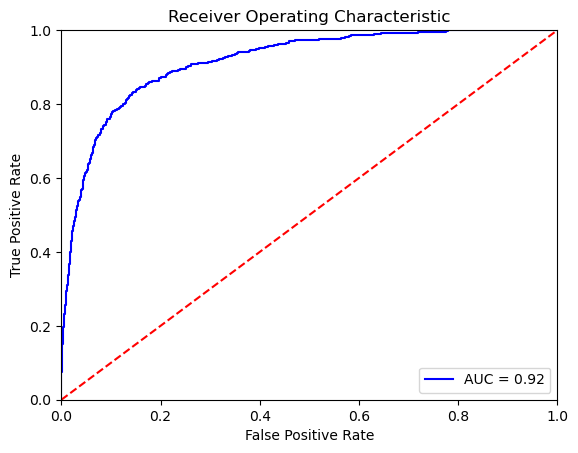

In [54]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.32%
------------------------------------------------
Confusion Matrix:
      0    1
0  5618   56
1   290  123
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.69      0.30      0.42       413

    accuracy                           0.94      6087
   macro avg       0.82      0.64      0.69      6087
weighted avg       0.93      0.94      0.93      6087



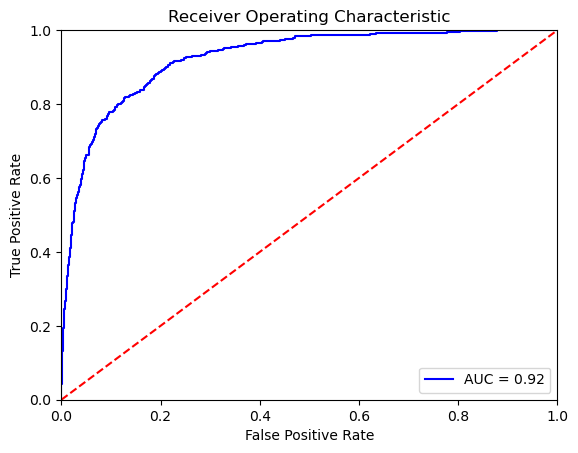

In [55]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.28%
------------------------------------------------
Confusion Matrix:
      0    1
0  5610   64
1   284  129
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.67      0.31      0.43       413

    accuracy                           0.94      6087
   macro avg       0.81      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



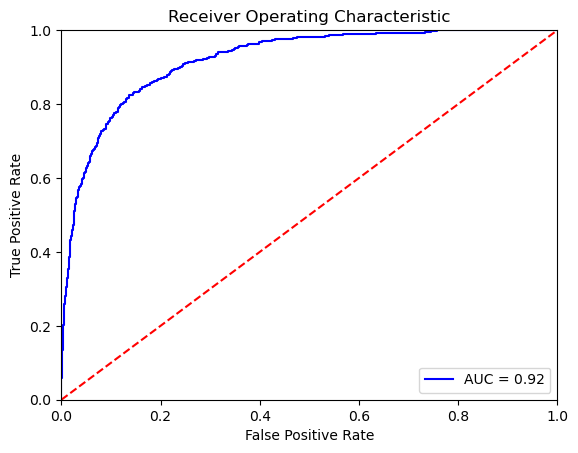

In [56]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:54] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 94.02%
------------------------------------------------
Confusion Matrix:
      0    1
0  5587   87
1   277  136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5674
           1       0.61      0.33      0.43       413

    accuracy                           0.94      6087
   macro avg       0.78      0.66      0.70      6087
weighted avg       0.93      0.94      0.93      6087



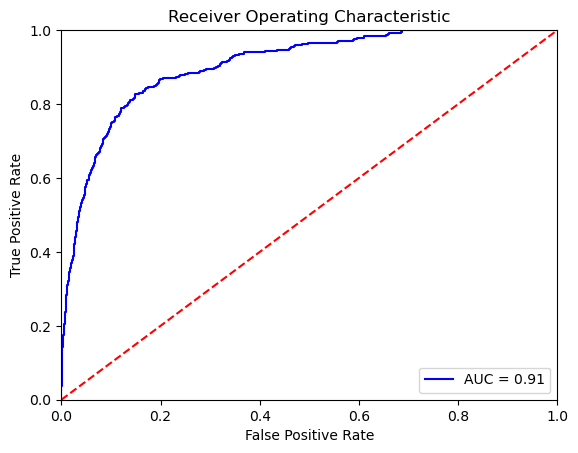

In [57]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.5730039	total: 12.2ms	remaining: 1.2s
1:	learn: 0.4868080	total: 24.2ms	remaining: 1.19s
2:	learn: 0.4125995	total: 36.8ms	remaining: 1.19s
3:	learn: 0.3622642	total: 50.3ms	remaining: 1.21s
4:	learn: 0.3207596	total: 66.1ms	remaining: 1.25s
5:	learn: 0.2891286	total: 83.6ms	remaining: 1.31s
6:	learn: 0.2623937	total: 100ms	remaining: 1.33s
7:	learn: 0.2485309	total: 115ms	remaining: 1.32s
8:	learn: 0.2306793	total: 131ms	remaining: 1.32s
9:	learn: 0.2178639	total: 146ms	remaining: 1.32s
10:	learn: 0.2106629	total: 160ms	remaining: 1.29s
11:	learn: 0.2038994	total: 172ms	remaining: 1.26s
12:	learn: 0.1974510	total: 186ms	remaining: 1.25s
13:	learn: 0.1928725	total: 199ms	remaining: 1.22s
14:	learn: 0.1886703	total: 213ms	remaining: 1.2s
15:	learn: 0.1847319	total: 227ms	remaining: 1.19s
16:	learn: 0.1813072	total: 239ms	remaining: 1.17s
17:	learn: 0.1781316	total: 252ms	remaining: 1.15s
18:	learn: 0.1762196	total: 267ms	remaining: 1.14s
19:	learn: 0.1739320	total: 281ms	rem

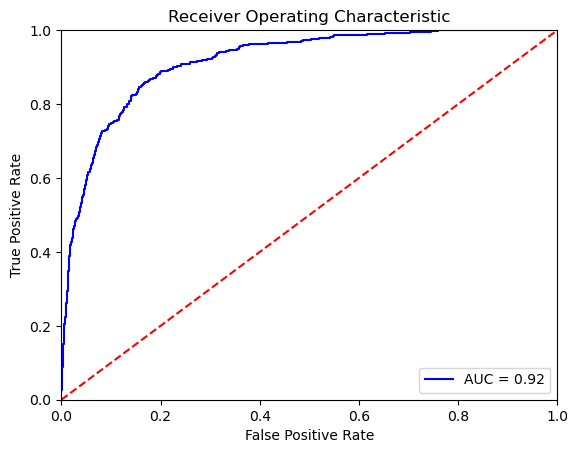

In [58]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 926, number of negative: 13275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 14201, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065207 -> initscore=-2.662764
[LightGBM] [Info] Start training from score -2.662764
model accuracy for classification is = 94.23%
------------------------------------------------
Confusion Matrix:
      0    1
0  5607   67
1   284  129
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.66      0.31      0.42       413

    accuracy                           0.94      6087
   macro avg       0.80      0.65      0.70      6087
weighted a

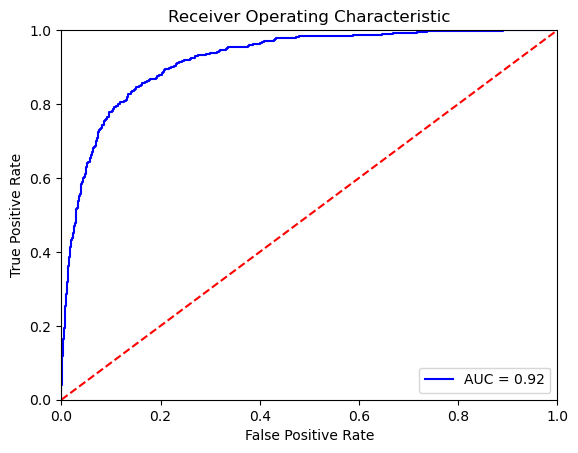

In [59]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 94.20%
------------------------------------------------
Confusion Matrix:
      0    1
0  5601   73
1   280  133
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5674
           1       0.65      0.32      0.43       413

    accuracy                           0.94      6087
   macro avg       0.80      0.65      0.70      6087
weighted avg       0.93      0.94      0.93      6087



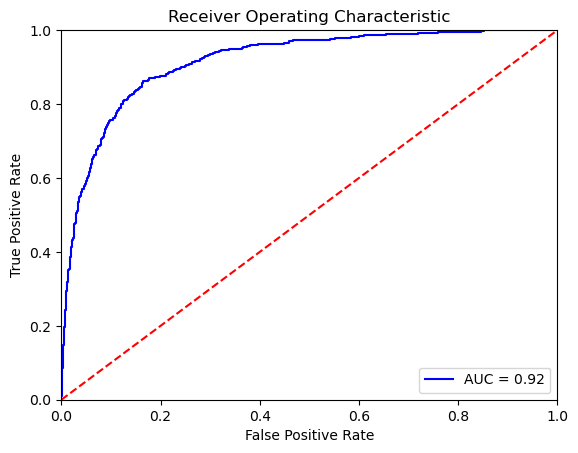

In [60]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [61]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove200d", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

### Model Evaluation

In [62]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
22,StackingClassifier-RF-SVC,untuned,tf,0.999789,0.996771,1.000000,0.998383,0.954657,0.740351,0.510896,0.604585
23,SVC,untuned,tf,0.996338,0.996591,0.947084,0.971207,0.955150,0.821101,0.433414,0.567353
12,RandomForest,untuned,tf,0.999859,1.000000,0.997840,0.998919,0.952029,0.871166,0.343826,0.493056
16,XGBoost,untuned,tf,0.965425,0.973856,0.482721,0.645487,0.947265,0.791139,0.302663,0.437828
34,StackingClassifier-RF-SVC,untuned,glove,0.972608,0.903759,0.649028,0.755500,0.942008,0.645631,0.322034,0.429725
28,XGBoost,untuned,glove,1.000000,1.000000,1.000000,1.000000,0.941679,0.639423,0.322034,0.428341
31,XGBoost,optuna,glove,0.999930,1.000000,0.998920,0.999460,0.940200,0.609865,0.329298,0.427673
30,XGBoost,randsearch,glove,0.999155,1.000000,0.987041,0.993478,0.942829,0.668394,0.312349,0.425743
33,LightGBM,untuned,glove,0.998592,1.000000,0.978402,0.989083,0.942336,0.658163,0.312349,0.423645
17,XGBoost,gridsearch,tf,0.971833,0.971326,0.585313,0.730458,0.943650,0.696629,0.300242,0.419628


In [63]:
evaluation.to_csv("eval/evaluation_olddata_rnn.csv")